![Screenshot from 2025-10-19 13-15-46.png](../screenshots/Screenshot_from_2025-10-19_13-15-46.png)

In [1]:
import os
from dotenv import load_dotenv
load_dotenv()

os.environ["OPENAI_API_KEY"]=os.getenv("OPENAI_API_KEY")
os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")
os.environ["TAVILY_API_KEY"]=os.getenv("TAVILY_API_KEY")

In [2]:
from langchain_groq import ChatGroq
llm=ChatGroq(model="llama-3.3-70b-versatile")
llm.invoke("hi I am sachchida. I am AI enthusiast")

AIMessage(content="Hello Sachchida! Nice to meet you! It's great to hear that you're an AI enthusiast. There are so many exciting developments and advancements in the field of Artificial Intelligence, from machine learning to natural language processing, and more.\n\nWhat specifically interests you about AI? Are you looking to learn more about a particular aspect of AI, or are you working on any AI-related projects? I'm here to help and chat with you about all things AI!", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 93, 'prompt_tokens': 46, 'total_tokens': 139, 'completion_time': 0.27265486, 'prompt_time': 0.002126569, 'queue_time': 0.055151441, 'total_time': 0.274781429}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_34d416ee39', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--a5ec0774-67af-4431-a242-7556b849f0b0-0', usage_metadata={'input_tokens': 46, 'output_tokens': 93, 'total_tokens': 139})

In [3]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START,END
from IPython.display import Image,display
from typing import Annotated, List
import operator
from pydantic import BaseModel, Field
from langchain_core.messages import HumanMessage,SystemMessage
from langgraph.graph import StateGraph,START,END
from IPython.display import Image,display

In [54]:
### custom tools

def multiply(a: int, b:int) -> int:
    """ multiply a and b.
        Args: 
            a: first int
            b: second int
    """
    print("multiply")
    return a*b

def add(a: int, b:int) -> int:
    """ add two numbers a and b.
        Args: 
            a: first int
            b: second int
    """
    print("add")
    return a+b

def divide(a: int, b:int) -> int:
    """ divide a and b.
        Args: 
            a: first int
            b: second int
    """
    print("divide")
    return a/b
tools=[add,multiply,divide]
tools

[<function __main__.add(a: int, b: int) -> int>,
 <function __main__.multiply(a: int, b: int) -> int>,
 <function __main__.divide(a: int, b: int) -> int>]

In [55]:
llm_with_tools=llm.bind_tools(tools)
llm_with_tools

RunnableBinding(bound=ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x763d27f20110>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x763d10e3dca0>, model_name='llama-3.3-70b-versatile', model_kwargs={}, groq_api_key=SecretStr('**********')), kwargs={'tools': [{'type': 'function', 'function': {'name': 'add', 'description': 'add two numbers a and b.\nArgs: \n    a: first int\n    b: second int', 'parameters': {'properties': {'a': {'type': 'integer'}, 'b': {'type': 'integer'}}, 'required': ['a', 'b'], 'type': 'object'}}}, {'type': 'function', 'function': {'name': 'multiply', 'description': 'multiply a and b.\nArgs: \n    a: first int\n    b: second int', 'parameters': {'properties': {'a': {'type': 'integer'}, 'b': {'type': 'integer'}}, 'required': ['a', 'b'], 'type': 'object'}}}, {'type': 'function', 'function': {'name': 'divide', 'description': 'divide a and b.\nArgs: \n    a: first int\n    b: second int', 'parameters': {'properties': 

In [56]:
### workflow with langgraph

from langgraph.prebuilt import tools_condition,ToolNode
from langgraph.graph import MessagesState
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.messages import AIMessage,HumanMessage,SystemMessage

## System Message -> Instruction to llm model how my llm model should behave
sys_msg=SystemMessage(content="You are a helpful assistant tasked with performing airthmatic on a set of input message")

### node

def assistant(state:MessagesState):
    return {"messages":[llm_with_tools.invoke([sys_msg]+state["messages"])]}

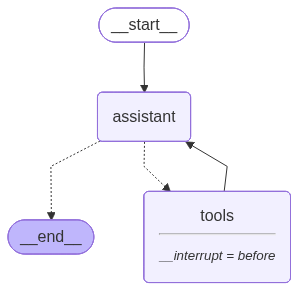

In [57]:
### Graph

builder=StateGraph(MessagesState)

## define the nodes

builder.add_node("assistant",assistant)
builder.add_node("tools",ToolNode(tools))

#### Define Edges

builder.add_edge(START,"assistant")
builder.add_conditional_edges("assistant",
                              tools_condition)
builder.add_edge("tools","assistant")

memory=MemorySaver()
### Human in loop
# graph=builder.compile(checkpointer=memory)
graph=builder.compile(interrupt_before=["assistant"],checkpointer=memory)
graph=builder.compile(interrupt_before=["tools"],checkpointer=memory)

display(Image(graph.get_graph().draw_mermaid_png()))


In [58]:
thread={"configurable":{"thread_id":"123"}}
initial_input={"message": HumanMessage(content="Multiply 2 and 3")}

In [59]:
for event in graph.stream(initial_input,thread,stream_mode="values"):
    event['messages'][-1].pretty_print()

================================== Ai Message ==================================

I'm ready to help with arithmetic operations. What are the numbers you'd like to work with?


In [60]:
state=graph.get_state(thread)
state.next

()

In [61]:
state

StateSnapshot(values={'messages': [AIMessage(content="I'm ready to help with arithmetic operations. What are the numbers you'd like to work with?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 432, 'total_tokens': 453, 'completion_time': 0.076339633, 'prompt_time': 0.038153878, 'queue_time': 0.050323451, 'total_time': 0.114493511}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_155ab82e98', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--de3737cd-3238-4563-805d-8e3a1a54185f-0', usage_metadata={'input_tokens': 432, 'output_tokens': 21, 'total_tokens': 453})]}, next=(), config={'configurable': {'thread_id': '123', 'checkpoint_ns': '', 'checkpoint_id': '1f0acc5e-9344-666a-8001-71464ae915c7'}}, metadata={'source': 'loop', 'step': 1, 'parents': {}}, created_at='2025-10-19T08:30:46.953726+00:00', parent_config={'configurable': {'thread_id': '123', 'checkpoint_ns': '', 'checkpoint_id': 

![../../screenshots/Screenshot from 2025-10-19 13-44-45.png](../screenshots/Screenshot_from_2025-10-19_13-44-45.png)

In [62]:
graph.get_state_history(thread)

<generator object Pregel.get_state_history at 0x763d0ba11640>

In [63]:
for event in graph.stream(None,thread,stream_mode="values"):
    event['messages'][-1].pretty_print()

================================== Ai Message ==================================

I'm ready to help with arithmetic operations. What are the numbers you'd like to work with?


In [39]:
state=graph.get_state(thread)
state.next

()

In [64]:
### To pass human message in interrupted flow
graph.update_state(thread,{"messages":[HumanMessage(content="No, pls multiply 15 and 6")]})

{'configurable': {'thread_id': '123',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0acc5f-49d6-65ef-8002-da841313bcf0'}}

In [65]:
new_state=graph.get_state(thread).values

for m in new_state['messages']:
    m.pretty_print()

================================== Ai Message ==================================

I'm ready to help with arithmetic operations. What are the numbers you'd like to work with?
================================ Human Message =================================

No, pls multiply 15 and 6


In [66]:
for event in graph.stream(None,thread,stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

No, pls multiply 15 and 6


### Wait for the user input
